Here we explore the rental data we scrap so far, see if we can find some interesting trend.

# load library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
%matplotlib inline

# load data

In [2]:
with open('14_11_2019_rentals_raw.csv') as f:
    df = pd.read_csv(f)

# some basic cleaning before eda

In [176]:
def data_clean(df):
    # price drop nan, should only contain numbers, drop the record if not.
    temp = df[~df['price'].isnull()]
    df = temp[temp['price'].str.isdigit()].reset_index(drop=True)
    # reformat some features
    df['price'] = df['price'].astype(float)
    # some price is not reasonable, drop them
    df = df.loc[df['price'] > 140,].reset_index(drop=True)
    df['suburb'] = df['address'].str.rsplit(',',1,expand=True)[1].str.strip()
    df['bond'] = df['bond'].str.split('$',expand=True)[1].str.replace(',','').astype(float)
    df['agent_suburb'] = df['agent_brand'].str.split('-',expand=True)[1]
    df['agent_brand'] = df['agent_brand'].str.split('-',expand=True)[0]
    temp = df['agent_name'].str.split(':',expand=True)
    replace = temp.loc[temp[0].str.lower() == 'agent',]
    old = temp.loc[temp[0].str.lower() != 'agent',]
    replace[0] = replace[1]
    df['agent_name'] = pd.concat([old,replace]).sort_index()[0]
    return df
df_clean = data_clean(df)

/Users/yaoyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


# EDA

## how many properties are listed today for each property type?

In [178]:
def plot_property_type(df_clean):
    plotdata = df_clean.groupby(['suburb','property_type']).count()['price'].unstack(level=1).reset_index().melt(id_vars='suburb',value_name='property_count')
    plt.figure(figsize=(24,10))
    sns.set(palette='muted',style="whitegrid", color_codes=True)
    ax = sns.barplot(x='property_type',y='property_count',hue='suburb',data=plotdata)
    plt.title('Property distributions across suburbs of Melbourne',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('Property Type',fontsize=18)
    ax.set_ylabel('Property Counts',fontsize=18)
    plt.legend(fontsize='x-large', title_fontsize='40',loc='upper right')

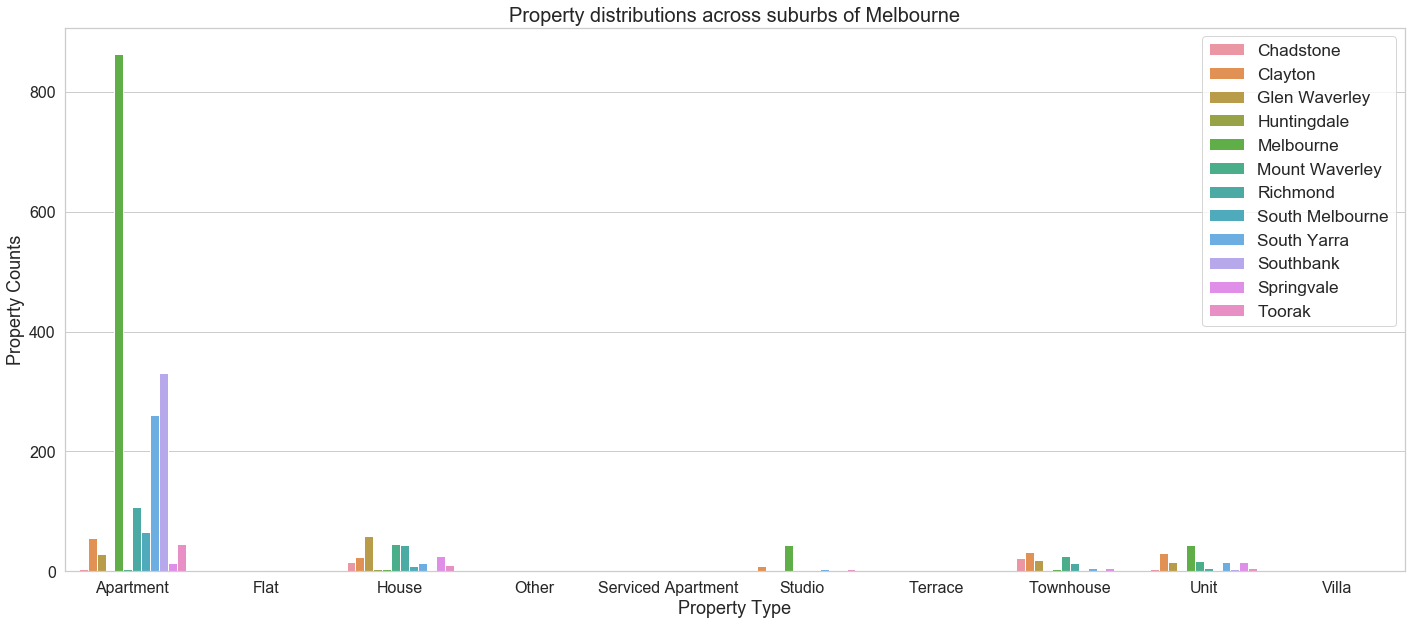

In [179]:
plot_property_type(df_clean)

+ Apparently most of the properties are apartments, which make sense :)
+ Melbourne suburbs have A LOT apartments...Impressive.
+ Melbourne suburbs have quite a few studios as well. Since it's so expansive to live in the city, so studio is a popular choices for people.

In [109]:
def plot_suburb_type(df_clean):
    plotdata = df_clean.groupby(['suburb','property_type']).count()['price'].unstack(level=1).reset_index().melt(id_vars='suburb',value_name='property_count')
    plt.figure(figsize=(24,10))
    sns.set(palette='muted',style="whitegrid", color_codes=True)
    ax = sns.barplot(x='suburb',y='property_count',hue='property_type',data=plotdata)
    plt.title('Property distributions across suburbs of Melbourne',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('Suburbs',fontsize=18)
    ax.set_ylabel('Property Counts',fontsize=18)
    plt.legend(fontsize='x-large', title_fontsize='40',loc='upper right')

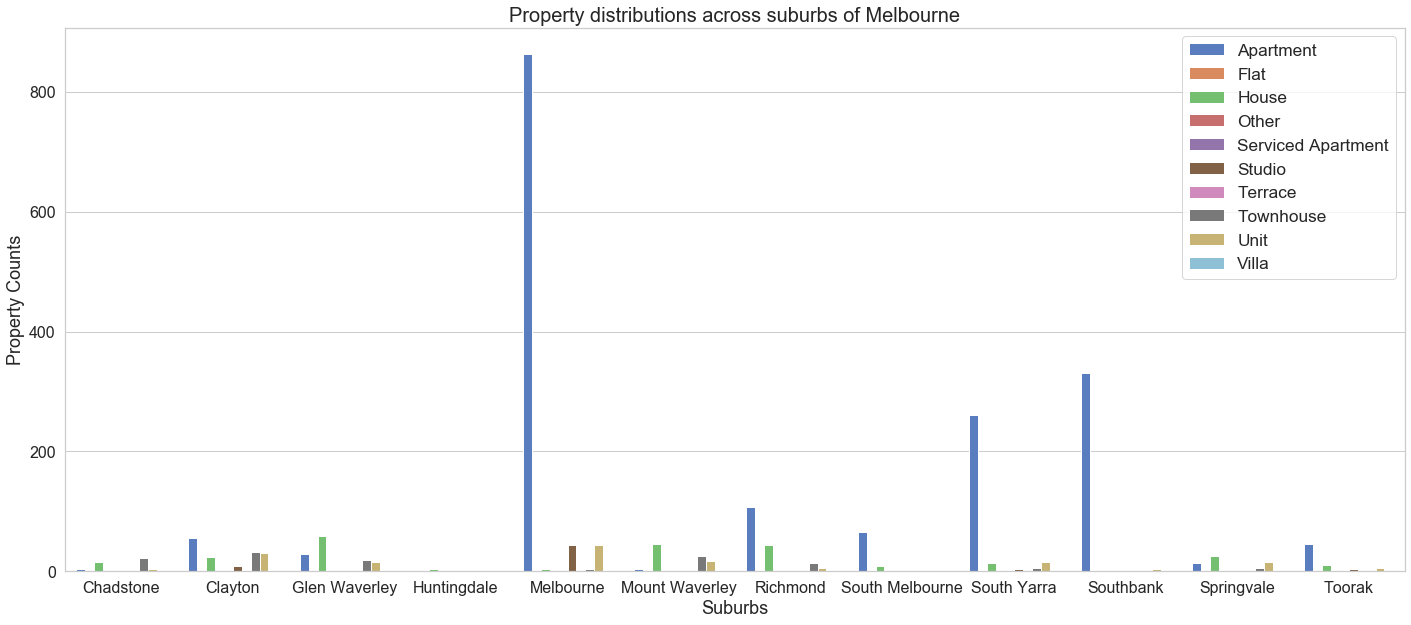

In [180]:
plot_suburb_type(df_clean)

+ just another view of the property count, see if I can find something else.
+ Chadstone, SpringVale, Mount Waverley, and Glen Waverley are suburbs have more houses than apartments. 

## What's the average rental price for suburbs?

In [152]:
def plot_avg_price(df_clean):
    plotdata = df_clean.loc[:,['property_type','price','suburb']]
    f,axes = plt.subplots(2,1,figsize=(24,20))
    sns.set(palette='muted',style="whitegrid", color_codes=True)
    sns.swarmplot(x='suburb',y='price',hue='property_type',data=plotdata,ax=axes[0])
    sns.boxplot(x='suburb',y='price',hue='property_type',data=plotdata,ax=axes[1])
    axes[0].set_title('Swarm Plot of Rental Price of Melbourne Suburbs',fontsize=16)
    axes[1].set_title('Box Plot of Rental Price of Melbourne Suburbs',fontsize=16)
    for i in range(2):
        axes[i].tick_params(axis='both', which='major', labelsize=16)
        axes[i].set_xlabel('Suburbs',fontsize=18)
        axes[i].set_ylabel('Price',fontsize=18)

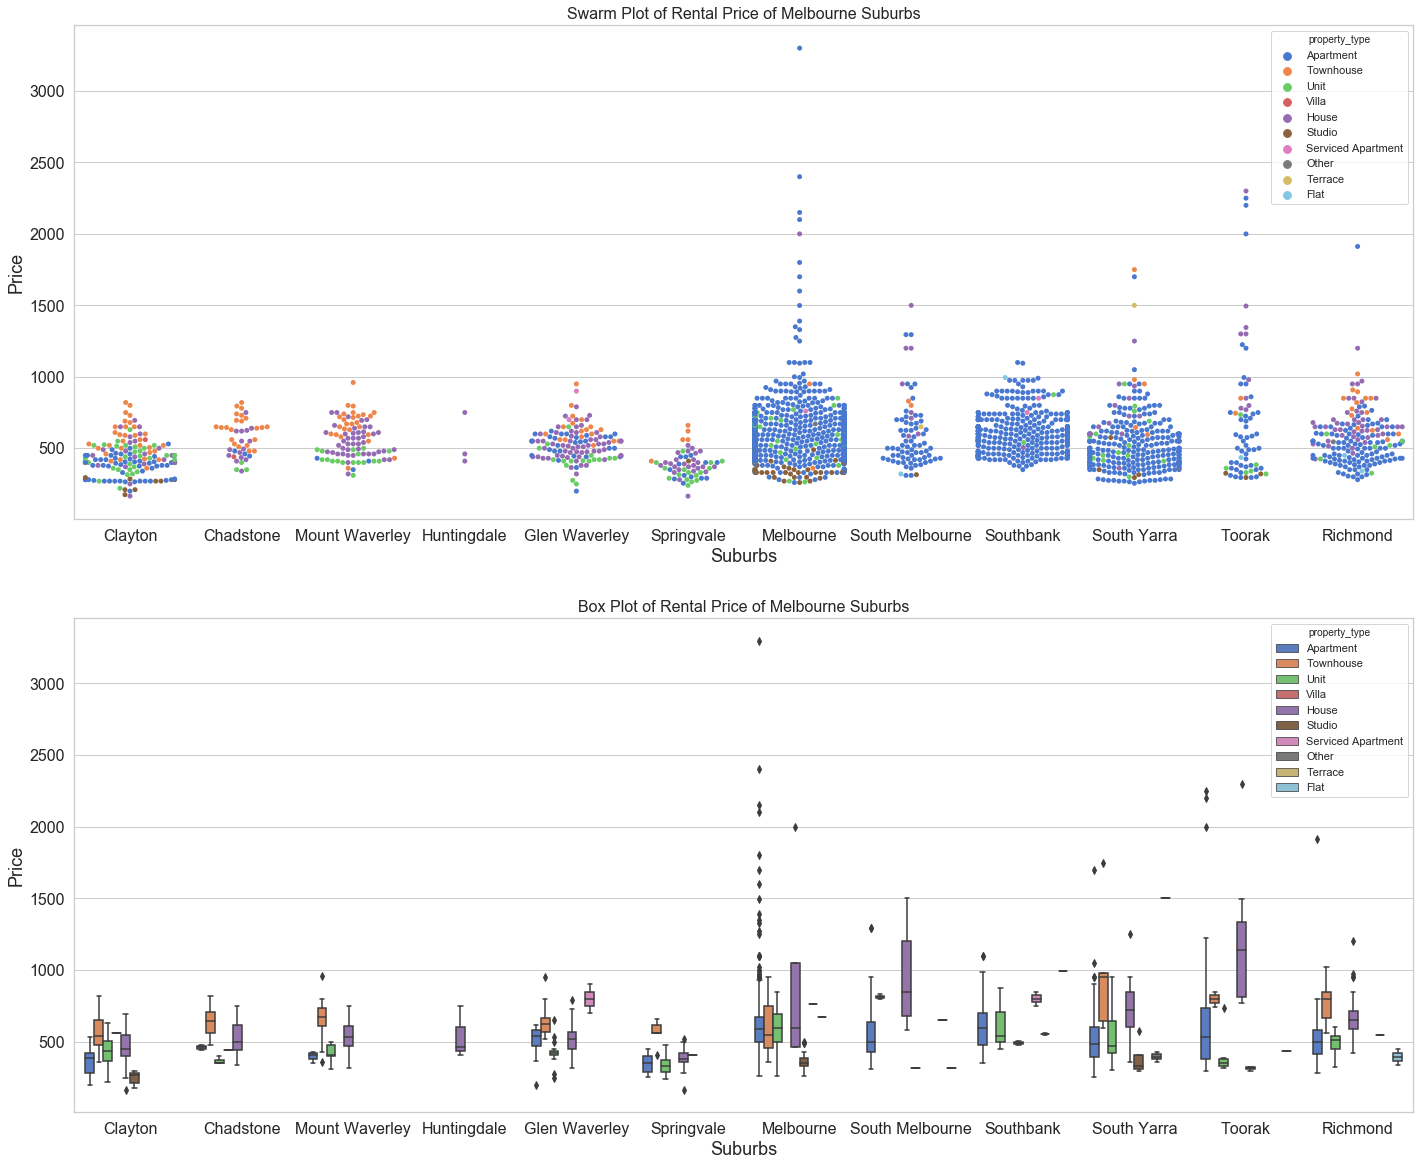

In [182]:
plot_avg_price(df_clean)

+ two different views of the rental price of all suburbs.
+ scatter point plots can show distribution more clearly. There are some extreme values present.
+ boxplots show mean price better, but I just don't like the style.
+ consider split the property_type and suburbs for a better visualization.
+ I also plot the bond as well, but they are almost the same. the bond should be one month rent, so they are linearly relationship.

In [222]:
def plot_avg_apt_price(df_clean):
    plotdata = df_clean.loc[df_clean['property_type'] == 'Apartment',['property_type','price','suburb']]
    plotorder = plotdata.groupby('suburb')['price'].median().sort_values(ascending=False).index
    medians = plotdata.groupby('suburb')['price'].median().sort_values(ascending=False).values
    median_labels = [str(np.round(s, 2)) for s in medians]
    #plot
    plt.figure(figsize=(24,10))
    sns.set(palette='muted',style="whitegrid", color_codes=True)
    ax = sns.boxplot(x='suburb',y='price',data=plotdata,order = plotorder)
    ax.set_ylim(0,1500)
    ax.set_title('Apartment Rental Price of Melbourne Suburbs',fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('Suburbs',fontsize=18)
    ax.set_ylabel('Price',fontsize=18)
    # refine plot
    pos = range(len(medians))
    for tick,label in zip(pos,ax.get_xticklabels()):
            ax.text(pos[tick], medians[tick] + 3, median_labels[tick], 
            horizontalalignment='center', size='large', color='k', weight='semibold')
    

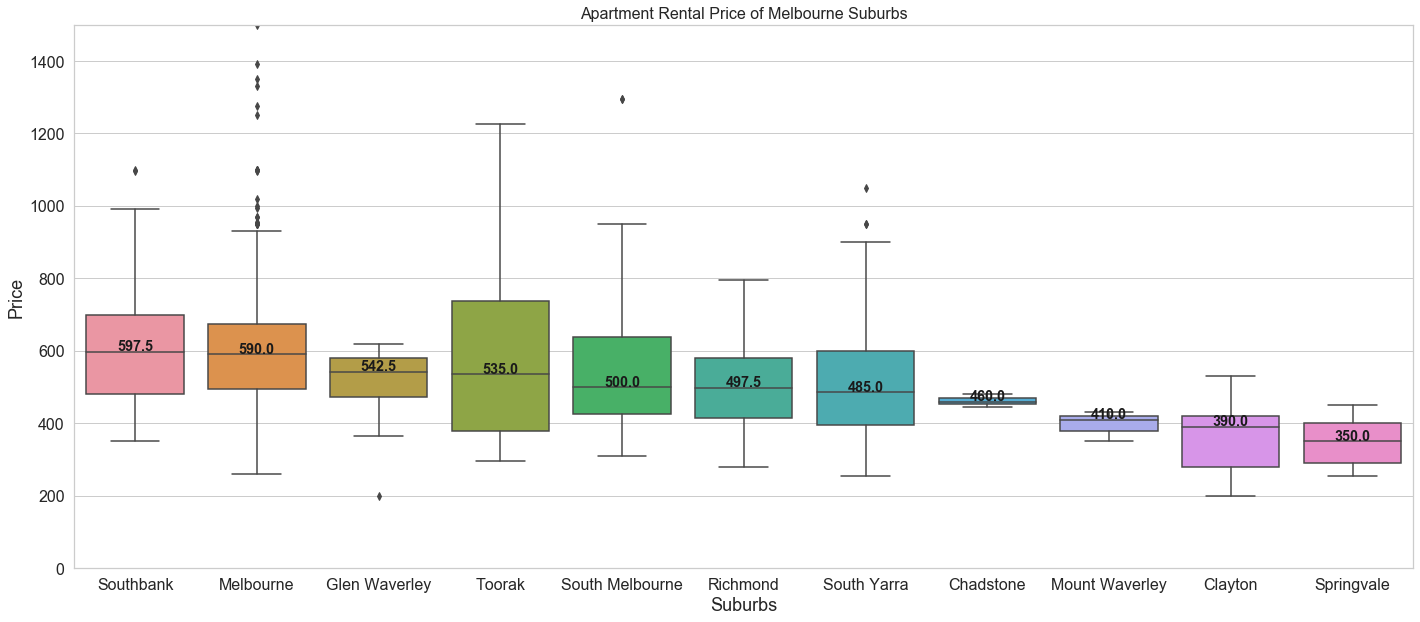

In [223]:
plot_avg_apt_price(df_clean)

+ The figure shows the average rental price for apartments of different suburbs.
+ The most expensive suburb is Southbank, while Melbourne suburb has quite a few very very expensive apartments, probably these skyhigh apartments.
+ The apartment rental price vary a lot in Toorak suburb.
+ This is an average of all apartments. of course 1b1b is cheaper than 2b1b, so next lets exam them separately

## Rental Price of Aparments: details

In [269]:
def plot_detail_apt_price(df_clean):
    plotdata = df_clean.loc[(df_clean['property_type'] == 'Apartment') & (df_clean['feature_bedroom'] <= 2) & (df_clean['feature_bedroom'] != 0),]
    plotdata = plotdata.loc[:,['price','suburb','feature_bedroom']]
    plotorder = plotdata.groupby('suburb')['price'].median().sort_values(ascending=False).index
    medians = plotdata.groupby('suburb')['price'].median().sort_values(ascending=False).values
    median_labels = [str(np.round(s, 2)) for s in medians]
    #plot
    plt.figure(figsize=(24,10))
    sns.set(palette='muted',style="whitegrid", color_codes=True)
    ax = sns.boxplot(x='suburb',y='price',hue='feature_bedroom',data=plotdata,order = plotorder)
    ax.set_ylim(0,1500)
    ax.set_title('Apartment Rental Price of Melbourne Suburbs',fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('Suburbs',fontsize=18)
    ax.set_ylabel('Price',fontsize=18)
    #plt.legend(title_fontsize=16)
    # refine plot
#     pos = range(len(medians))
#     for tick,label in zip(pos,ax.get_xticklabels()):
#             ax.text(pos[tick], medians[tick] + 3, median_labels[tick], 
#             horizontalalignment='center', size='large', color='k', weight='semibold')
    
    

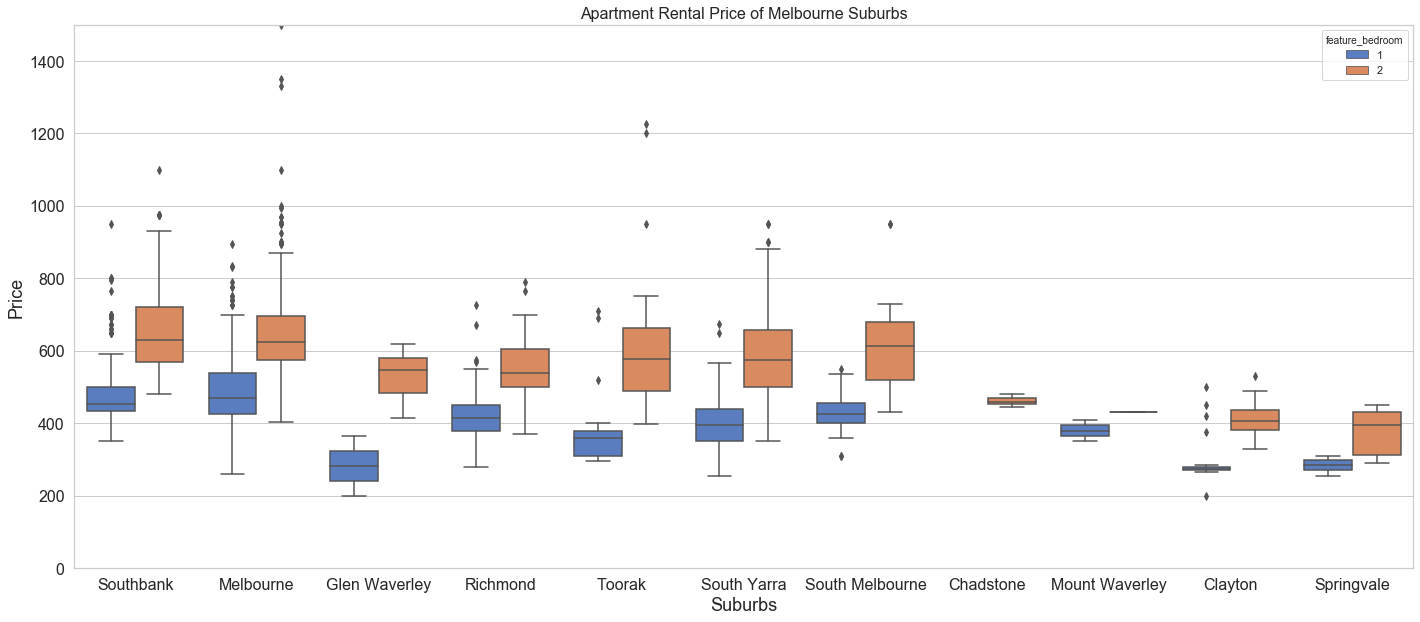

In [270]:
plot_detail_apt_price(df_clean)

+ It seems like Glen Waverley's 1 bedroom apartments are just cheaper than usual